# Advantage experiment

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pylab as plt

def calculate_modularity_matrix(graph, res) -> np.ndarray:
        adj_matrix: np.ndarray = nx.to_numpy_array(
            graph)
        degree_matrix: np.ndarray = adj_matrix.sum(axis=1)
        m: int = np.sum(degree_matrix)
        return (
            adj_matrix
            - res * np.outer(degree_matrix, degree_matrix) / m
        )

def generalized_modularity_matrix(graph, community, res=1) -> np.ndarray:
        community = list(community)
        full_B = calculate_modularity_matrix(graph, res)

        B_bis = full_B[community,:]
        B_community = B_bis[:,community]
        B_i = np.sum(B_community, axis=-1)
        delta = np.eye(len(community), dtype=np.int32)
        B_g = B_community - delta*B_i

        return B_g

In [3]:
def energy_state(state, modularity, degrees, m, resolution=1):
  state = np.array(state, dtype=np.int16)
  degrees = np.array(degrees, dtype=np.float32)
  Q = -(1/m)*(state @ modularity @ state.T) + ((1-resolution)/m)*(degrees@state.T) - (1-resolution)/2
  return Q

In [4]:
import netgraph

def plot_network_in_communities(graph, comms, filename=None, community_to_color=None, hub_size=False, node_labels=False):
  if hub_size==False:
    eigen_centrality = 3
  else:
    eigen_centrality = {node: hub_size*eigen for node, eigen in nx.eigenvector_centrality(graph).items()}

  node_to_community = dict()
  for community_id, c in enumerate(comms):
      for node in c:
          node_to_community[node] = community_id
  if community_to_color==None:
    community_to_color = np.random.rand(community_id+1,3)
  node_color = {node: community_to_color[community_id] for node, community_id in node_to_community.items()}

  netgraph.Graph(graph,
        node_color=node_color, edge_alpha=1,
        node_layout='community', node_layout_kwargs=dict(node_to_community=node_to_community),
        edge_color="black", node_edge_width=0.1, node_size=eigen_centrality,
        edge_width=0.25, node_labels=node_labels, node_label_fontdict={"size": 10}
  )
  if filename is not None:
    plt.savefig(filename, bbox_inches='tight')
    print("\nYour plot is saved to {}".format(filename))
  else:
    plt.show()

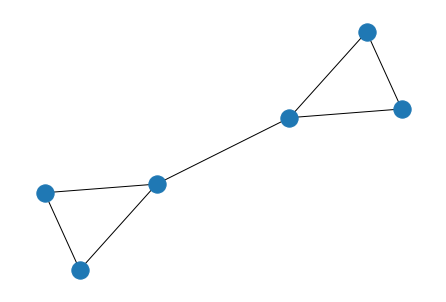

In [5]:
# Create empty graph
G = nx.Graph()

# Resolution
res = 1

# Add edges to the graph (also adds nodes)
G.add_edges_from([(0,1),(1,2),(0,2), (3,4),(4,5),(5,3), (5,0)])
nx.draw(G, )

## (Real) First level using Advanage

In [5]:
import sympy
from QHyper.util import Expression
from typing import Union

VARIABLES = Union[tuple[()], tuple[str], tuple[str, str], tuple[str, ...]]

def set_objective_function(B, degrees, resolution):
    equation: dict[VARIABLES, float] = {}
    for i in range(len(B)):
        for j in range(len(B)):
            for case_val in range(2):
                x_i, x_j = sympy.symbols(f"x{i}"), sympy.symbols(f"x{j}")
                x_i, x_j = str(x_i), str(x_j)
                equation[(x_i, x_j)] = B[i, j]
                if i == j:
                    equation[(x_i, x_j)] -= ((1 - resolution) * 
                                                np.array(degrees, dtype=np.float32)[i])

    equation = {key: -1 * val for key, val in equation.items()}

    objective_function = Expression(equation)
    return objective_function.as_dict()

In [6]:
from collections import defaultdict

def set_automatic_objective_function(B, community, degrees, resolution):
    Q = defaultdict(int)
    for i in range(len(B)):
        for j in range(len(B)):
            c_i, c_j = f"x{community[i]}", f"x{community[j]}"
            Q[(c_i, c_j)] = -B[i, j]
            if i == j:
                Q[(c_i, c_j)] += ((1 - resolution) * 
                                   np.array(degrees, dtype=np.float32)[i])

    return Q

In [7]:
def find_differences_in_lists(list1, list2):
    if len(list1) != len(list2):
        return "Lists have different lengths"

    different_indices = []

    for i in range(len(list1)):
        if list1[i] != list2[i]:
            different_indices.append(i)

    return different_indices

In [8]:
def get_value(dictionary):
    result = []
    for i in range(len(dictionary)):
        key = f"x{i}" 
        result.append(dictionary.get(key, None))
    return result

In [9]:
from dwave.system import DWaveSampler, EmbeddingComposite

KARATE = nx.karate_club_graph()
c = [*range(34)]

B_KARATE = calculate_modularity_matrix(KARATE, res=1) #same as calculate_modularity_matrix()
_, degrees_KARATE = zip(*dict(nx.degree(KARATE)).items()) 

sampler = DWaveSampler(region="eu-central-1", solver='Advantage_system5.4')
Q = set_objective_function(B_KARATE, degrees_KARATE, 1)
sampleset_0 = EmbeddingComposite(sampler).sample_qubo(Q)
print(sampleset_0)

ground_state_0 = get_value(sampleset_0.first.sample)
# -93.238095 

  x0 x1 x10 x11 x12 x13 x14 x15 x16 x17 x18 x19 ... x9     energy num_oc. ...
0  0  0   0   0   0   0   1   1   0   0   1   0 ...  1 -93.238095       1 ...
['BINARY', 1 rows, 1 samples, 34 variables]


In [11]:
c01 = [c[k] for k,v in enumerate(ground_state_0) if v == 1]
c02 = [c[k] for k,v in enumerate(ground_state_0) if v == 0]

In [12]:
print(find_differences_in_lists(c02, [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21]))
print(c02)
print([0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21]) # Given in Joan's file

[]
[0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21]
[0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21]


In [13]:
print(find_differences_in_lists(c01, [8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]))
print(c01)
print([8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]) # Given in Joan's file

[]
[8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
[8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]


Depending on the approach, sometimes the vertices are not selected in the same way (1 or 2 vertices are different from Joan's data) \
We will continue with calculated values

## First (second) level

### Classical approach

In [14]:
KARATE = nx.karate_club_graph()

c1, c2 = [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21], [8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
B_KARATE = calculate_modularity_matrix(KARATE, 1)
_, degrees_KARATE = zip(*dict(nx.degree(KARATE)).items()) 
m_KARATE = 0.5*np.sum(degrees_KARATE)  

B_KARATE_1 = generalized_modularity_matrix(KARATE, c1, res=1)
degrees_KARATE_1 = np.array(degrees_KARATE, dtype=np.int32)[c1]

B_KARATE_2 = generalized_modularity_matrix(KARATE, c2, res=1)
degrees_KARATE_2 = np.array(degrees_KARATE, dtype=np.int32)[c2]

In [15]:
import itertools

def calculate_partition(G, c, degree, m):
  qbits = len(c)
  states = []
  for x in itertools.product(range(2), repeat=qbits):
    states.append(x)
  assert len(states) == 2**qbits

  energies = {}
  for s in states:
    energies[s] = energy_state(s, G, degree, m, resolution=1)

  ground_state, ground_energy = min(energies, key=energies.get), min(energies.values())
  return ground_state, ground_energy


In [16]:
ground_state1, ground_energy1 = calculate_partition(B_KARATE_1, c1, degrees_KARATE_1, m_KARATE)
ground_state2, ground_energy2 = calculate_partition(B_KARATE_2, c2, degrees_KARATE_2, m_KARATE)

print("Partition of c1: ", ground_state1, " and energy: ", ground_energy1)
print("Partition of c2: ", ground_state2, " and energy: ", ground_energy2)

Partition of c1:  (0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0)  and energy:  -0.09149184149184149
Partition of c2:  (1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1)  and energy:  -0.030747030747030807


### Advantage approach

In [17]:
sampler = DWaveSampler(region="eu-central-1", solver='Advantage_system5.4')
Q = set_objective_function(B_KARATE_1, degrees_KARATE_1, 1)
sampleset_1 = EmbeddingComposite(sampler).sample_qubo(Q)
print(sampleset_1)

get_value(sampleset_1.first.sample)

  x0 x1 x10 x11 x12 x13 x14 x15 x2 x3 x4 x5 x6 x7 x8 x9    energy num_oc. ...
0  1  1   1   1   0   1   1   1  1  1  0  0  0  1  0  1 -7.136364       1 ...
['BINARY', 1 rows, 1 samples, 16 variables]


[1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1]

In [18]:
B_KARATE_2 = generalized_modularity_matrix(KARATE, c2, res=1)
degrees_KARATE_2 = np.array(degrees_KARATE, dtype=np.int32)[c2]

sampler = DWaveSampler(region="eu-central-1", solver='Advantage_system5.4')
Q = set_objective_function(B_KARATE_2, degrees_KARATE_2, 1)
sampleset_2 = EmbeddingComposite(sampler).sample_qubo(Q)
print(sampleset_2)

get_value(sampleset_2.first.sample)

  x0 x1 x10 x11 x12 x13 x14 x15 x16 x17 x2 x3 x4 x5 ... x9 energy num_oc. ...
0  1  1   1   1   1   1   1   1   1   1  1  1  1  1 ...  1   -0.0       1 ...
['BINARY', 1 rows, 1 samples, 18 variables]


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

### Comparason

In [19]:
print(find_differences_in_lists(get_value(sampleset_1.first.sample), list(ground_state1)))

print(list(ground_state1))
print(get_value(sampleset_1.first.sample))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
[1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1]


In [20]:
print(find_differences_in_lists(get_value(sampleset_2.first.sample), list(ground_state2)))

print(list(ground_state2))
print(get_value(sampleset_2.first.sample))

[7, 8, 9, 11, 12, 15]
[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


Earlier, when I ran the solver, the data came out exactly the same as Joan's - there is a certain risk of randomness

#### Classical approach graphs

In [21]:
c11 = [c1[k] for k,v in enumerate(ground_state1) if v == 0]
c12 = [c1[k] for k,v in enumerate(ground_state1) if v == 1]
c21 = [c2[k] for k,v in enumerate(ground_state2) if v == 0]
c22 = [c2[k] for k,v in enumerate(ground_state2) if v == 1]

c:\Users\Kacper\AppData\Local\Programs\Python\Python310\lib\site-packages\netgraph\_main.py:301: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (node_size[node] < node_edge_width[node]) & (node_color[node] != node_edge_color[node]):
c:\Users\Kacper\AppData\Local\Programs\Python\Python310\lib\site-packages\netgraph\_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


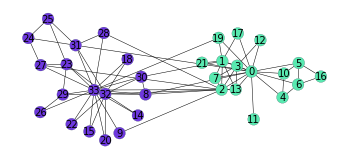

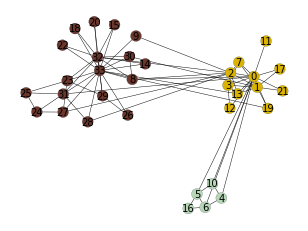

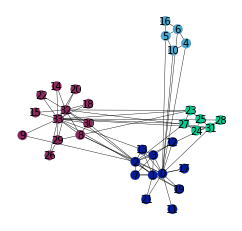

In [22]:
plot_network_in_communities(KARATE, [c11+c12,c21+c22], filename=None, community_to_color=None, hub_size=False, node_labels=True)
plot_network_in_communities(KARATE, [c11,c12,c21+c22], filename=None, community_to_color=None, hub_size=False, node_labels=True)
plot_network_in_communities(KARATE, [c11,c12,c21,c22], filename=None, community_to_color=None, hub_size=False, node_labels=True)

#### Advantage approach graphs

In [23]:
a11 = [c1[k] for k,v in enumerate(get_value(sampleset_1.first.sample)) if v == 0]
a12 = [c1[k] for k,v in enumerate(get_value(sampleset_1.first.sample)) if v == 1]
a21 = [c2[k] for k,v in enumerate(get_value(sampleset_2.first.sample)) if v == 0]
a22 = [c2[k] for k,v in enumerate(get_value(sampleset_2.first.sample)) if v == 1]

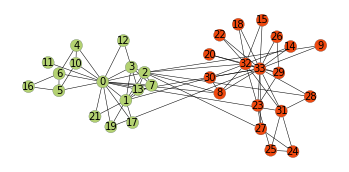

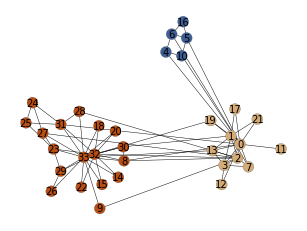

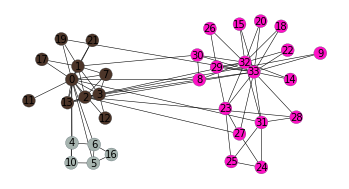

In [24]:
plot_network_in_communities(KARATE, [a11+a12,a21+a22], filename=None, community_to_color=None, hub_size=False, node_labels=True)
plot_network_in_communities(KARATE, [a11,a12,a21+a22], filename=None, community_to_color=None, hub_size=False, node_labels=True)
plot_network_in_communities(KARATE, [a11,a12,a21,a22], filename=None, community_to_color=None, hub_size=False, node_labels=True)

## One level deeper!

### Classical solution

In [25]:
B_KARATE_11 = generalized_modularity_matrix(KARATE, c11)

degrees_KARATE_11 = np.array(degrees_KARATE, dtype=np.int32)[c11]
ground_state_11, ground_energy_11 = calculate_partition(B_KARATE_11, c11, degrees_KARATE_11, m_KARATE)

print("Partition of c11: ", ground_state_11, " and energy: ", ground_energy_11)

Partition of c11:  (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)  and energy:  0.0


In [26]:
B_KARATE_12 = generalized_modularity_matrix(KARATE, c12)

degrees_KARATE_12 = np.array(degrees_KARATE, dtype=np.int32)[c12]
ground_state_12, ground_energy_12 = calculate_partition(B_KARATE_12, c12, degrees_KARATE_12, m_KARATE)

print("Partition of c12: ", ground_state_12, " and energy: ", ground_energy_12)

Partition of c12:  (1, 1, 1, 1, 1)  and energy:  -2.348548705937831e-17


In [27]:
B_KARATE_21 = generalized_modularity_matrix(KARATE, c21)

degrees_KARATE_21 = np.array(degrees_KARATE, dtype=np.int32)[c21]
ground_state_21, ground_energy_21 = calculate_partition(B_KARATE_21, c21, degrees_KARATE_21, m_KARATE)

print("Partition of c21: ", ground_state_21, " and energy: ", ground_energy_21)

Partition of c21:  (0, 0, 0, 0, 0, 0)  and energy:  0.0


In [28]:
B_KARATE_22 = generalized_modularity_matrix(KARATE, c22)

degrees_KARATE_22 = np.array(degrees_KARATE, dtype=np.int32)[c22]
ground_state_22, ground_energy_22 = calculate_partition(B_KARATE_22, c22, degrees_KARATE_22, m_KARATE)

print("Partition of c22: ", ground_state_22, " and energy: ", ground_energy_22)

Partition of c22:  (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)  and energy:  -4.270088556250602e-17


### And Advantage

In [29]:
sampler = DWaveSampler(region="eu-central-1", solver='Advantage_system5.4')
Q = set_objective_function(B_KARATE_11, degrees_KARATE_11, 1)
sampleset_11 = EmbeddingComposite(sampler).sample_qubo(Q)
print(sampleset_11)

get_value(sampleset_11.first.sample)

  x0 x1 x10 x2 x3 x4 x5 x6 x7 x8 x9 energy num_oc. chain_.
0  1  1   1  1  1  1  1  1  1  1  1    0.0       1     0.0
['BINARY', 1 rows, 1 samples, 11 variables]


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [30]:
sampler = DWaveSampler(region="eu-central-1", solver='Advantage_system5.4')
Q = set_objective_function(B_KARATE_11, degrees_KARATE_11, 1)
sampleset_12 = EmbeddingComposite(sampler).sample_qubo(Q)
print(sampleset_12)

get_value(sampleset_12.first.sample)

  x0 x1 x10 x2 x3 x4 x5 x6 x7 x8 x9 energy num_oc. chain_.
0  1  1   1  1  1  1  1  1  1  1  1    0.0       1     0.0
['BINARY', 1 rows, 1 samples, 11 variables]


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [31]:
sampler = DWaveSampler(region="eu-central-1", solver='Advantage_system5.4')
Q = set_objective_function(B_KARATE_11, degrees_KARATE_11, 1)
sampleset_21 = EmbeddingComposite(sampler).sample_qubo(Q)
print(sampleset_21)

get_value(sampleset_21.first.sample)

  x0 x1 x10 x2 x3 x4 x5 x6 x7 x8 x9 energy num_oc. chain_.
0  0  0   0  0  0  0  0  0  0  0  0    0.0       1     0.0
['BINARY', 1 rows, 1 samples, 11 variables]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [32]:
sampler = DWaveSampler(region="eu-central-1", solver='Advantage_system5.4')
Q = set_objective_function(B_KARATE_11, degrees_KARATE_11, 1)
sampleset_22 = EmbeddingComposite(sampler).sample_qubo(Q)
print(sampleset_22)

get_value(sampleset_22.first.sample)

  x0 x1 x10 x2 x3 x4 x5 x6 x7 x8 x9 energy num_oc. chain_.
0  0  0   0  0  0  0  0  0  0  0  0    0.0       1     0.0
['BINARY', 1 rows, 1 samples, 11 variables]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

## Automatic division

In [12]:
def hierarchical_search(G, sampler, community = False, resolution=1, chainstrength=8, numruns=500, level = 1):
    if not community:
            community = [*range(G.number_of_nodes())]
            
    print("===========================================")
    print("Calculations for graph with", len(community), "nodes, level of recursion:", level)
    print("===========================================")

    B = generalized_modularity_matrix(G, community, resolution)
    _, degrees = zip(*dict(nx.degree(G)).items())
    Q = set_automatic_objective_function(B, community, degrees, resolution)

    response = EmbeddingComposite(sampler).sample_qubo(Q,
                               chain_strength=chainstrength,
                               num_reads=numruns,
                               label='Hierarchical community detection')

    sample = response.first.sample

    c0, c1 = [], []
    for i in community:
        value = sample.get(f"x{i}" , None)
        if value == 0:
            c0.append(i)
        else:
            c1.append(i)

    print("Base community:")
    print(community)
    print("Community division:")
    print(c0)
    print(c1)
    print("===========================================\n")

    if c0 and c1:
        return hierarchical_search(G, sampler, community=c0, level=level+1) + hierarchical_search(G, sampler, community=c1, level=level+1)
    elif c0:
        return [c0]
    else:
        return [c1]

In [13]:
sampler = DWaveSampler(region="eu-central-1", solver='Advantage_system5.4')
G = nx.karate_club_graph()
t = hierarchical_search(G, sampler)

print("Final result:")
print(t)

Calculations for graph with 34 nodes, level of recursion: 1
Base community:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
Community division:
[0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21]
[8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]

Calculations for graph with 16 nodes, level of recursion: 2
Base community:
[0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21]
Community division:
[0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21]
[4, 5, 6, 10, 16]

Calculations for graph with 11 nodes, level of recursion: 3
Base community:
[0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21]
Community division:
[0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21]
[]

Calculations for graph with 5 nodes, level of recursion: 3
Base community:
[4, 5, 6, 10, 16]
Community division:
[]
[4, 5, 6, 10, 16]

Calculations for graph with 18 nodes, level of recursion: 2
Base community:
[8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27

In [23]:
sampler = DWaveSampler(region="eu-central-1", solver='Advantage_system5.4')
FFG = nx.davis_southern_women_graph()
dswg_modularity_list = []

for i in range(5):
    t = hierarchical_search(FFG, sampler)
    listS = []
    for i in nx.davis_southern_women_graph():
        listS.append(i)
    mapped_list = [[listS[i] for i in group] for group in t]
    result = nx.community.modularity(FFG, mapped_list)
    dswg_modularity_list.append(result)
    print(dswg_modularity_list)

[0.32098219921727056]
[0.32098219921727056, 0.3318394142153769]


SolverFailureError: Problem not accepted because user has insufficient remaining solver access time in project DEV